In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

from StorageEnvEffLos_rate import IdealStorageShutdownEnv

from tools import denormalize

In [11]:
# Import oracle result
import json

# Open the JSON file in read mode and load its content into a Python dictionary
with open('./data/oracle.json', 'r') as file:
    oracle = json.load(file)

print(oracle)

{'P': [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.9952000000000107, 0.7452000000000107, 0.5, 0.7150459437698943, 0.95, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.105600000000012, 0.855600000000012, 0.605600000000012, 0.5, 0.5, 0.75, 0.95, 1.2, 1.2, 1.2, 1.2, 1.0, 0.75, 0.5, 0.5, 0.5, 0.6150000000000091, 0.8650000000000091, 1.115000000000009, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.95, 0.7, 0.5, 0.5, 0.5, 0.5, 0.75, 0.95, 1.2, 0.95, 0.7452000000000083, 0.5, 0.5, 0.5, 0.5, 0.7, 0.95, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.95, 0.7, 0.5, 0.5, 0.5, 0.7452000000000107, 0.9952000000000107, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.95, 0.7, 0.5, 0.5, 0.7452000000000107, 0.7452000000000109, 0.95, 1.115000000000009, 1.2, 0.95, 0.7452000000000107, 0.5, 0.5, 0.5, 0.5, 0.6150000000000091, 0.8650000000000091, 1.115000000000009, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1454076409208462, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1

In [12]:
# Read your CSV file (adjust the path if necessary)
df = pd.read_csv('./data/DayAheadSpotPrices.csv')
two_days_forecast = pd.read_csv("./data/two_days_forecast.csv")
# Check the number of rows in the DataFrame to ensure it matches 8760
print("Number of data points:", len(df))

# Create a date range for the year 2017 with hourly frequency
timestamps = pd.date_range(start='2017-01-01 00:00:00', periods=len(df), freq='H')

# Add the timestamp column to the DataFrame
df['timestamp'] = timestamps

# Optionally, set the timestamp column as the DataFrame index (if needed)
df.set_index('timestamp', inplace=True)

# Extract the 'price' column and reshape to a 2D array
prices = df['2017'].values.reshape(-1, 1)
prices = prices.flatten()

Number of data points: 8760


In [ ]:
test_price = df['2017'].loc['2017-09-03':'2017-09-09'].to_numpy()

model = PPO.load("./model/ppo_energy_storage.zip")

env_test = IdealStorageShutdownEnv(
    S_max=6,
    Delta_max=0.25,
    theta_min=0.5, 
    theta_max=0.2,
    zeta=0.02,
    cEl=test_price
)
obs, _ = env_test.reset(S0_rand=False)  # Unpack to get only the observation
# Lists to store the recorded data
obs_list = []
# Lists to record normalized data during testing
norm_obs_list = []    # normalized observations
norm_action_list = [] # normalized actions
reward_list = []
time_steps = []

done = False
step_count = 0

# Run the environment until the episode is done
while not done:
    # Predict the action (normalized action is returned)
    norm_action, _states = model.predict(obs, deterministic=True)
    
    # Step in the environment using the normalized action
    obs, reward, done, info, _ = env_test.step(norm_action)
    
    # Record the normalized observation, normalized action, and reward
    norm_obs_list.append(obs)
    norm_action_list.append(norm_action[0])  # record the single value
    reward_list.append(reward)
    time_steps.append(step_count)
    env_test.render()
    
    step_count += 1
# Convert recorded lists to NumPy arrays
norm_obs_array = np.array(norm_obs_list)        # shape: (num_steps, 4)
norm_action_array = np.array(norm_action_list)    # shape: (num_steps,)
reward_array = np.array(reward_list)

Time=1, S=-0.29, P_prev=0.71, price=29.800, demand_pen=0.00, ramp_pen=0.58, unmatched demand=0.00
Time=2, S=-0.77, P_prev=0.53, price=28.120, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=3, S=-1.18, P_prev=0.59, price=27.600, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=4, S=-1.56, P_prev=0.62, price=27.640, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=5, S=-1.91, P_prev=0.65, price=28.080, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=6, S=-2.23, P_prev=0.68, price=27.630, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=7, S=-2.49, P_prev=0.74, price=29.450, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=8, S=-2.78, P_prev=0.72, price=30.250, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=9, S=-3.03, P_prev=0.75, price=29.320, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=10, S=-3.20, P_prev=0.83, price=30.090, demand_pen=0.00, ramp_pen=0.00, unmatched demand=0.00
Time=11, S=-3.36, P

Total cost: 5236.004586219788
Storage decreases by 4.4098734855651855


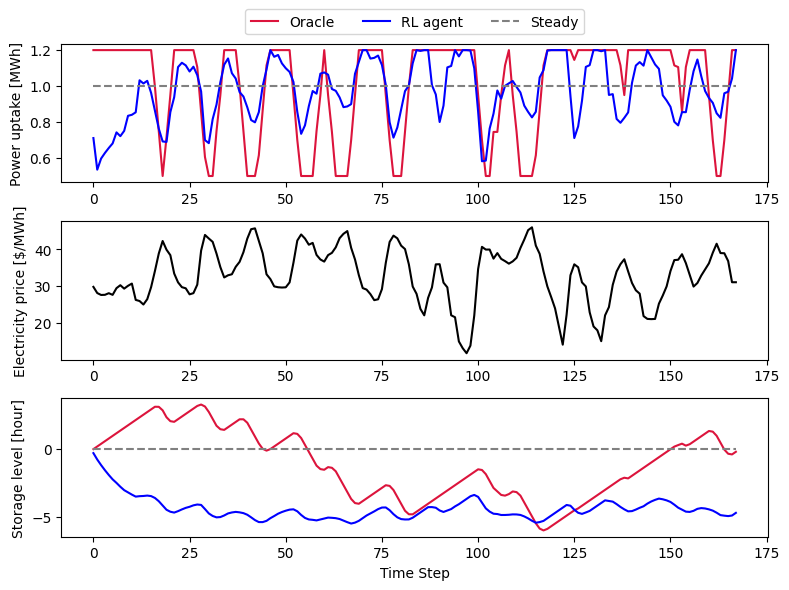

In [14]:
# Denormalize observations using the environment's true range:
# env_test.obs_low and env_test.obs_high are arrays of shape (4,)
denorm_obs_array = denormalize(norm_obs_array, env_test.obs_low, env_test.obs_high)

# Denormalize actions using the environment's true action range:
# env_test.act_low and env_test.act_high are arrays of shape (1,)
denorm_action_array = denormalize(norm_action_array, env_test.act_low[0], env_test.act_high[0])

power_oracle = oracle['P']
storage_oracle = oracle['S']

# Plotting the denormalized data
plt.figure(figsize=(8, 6))

# Plot Denormalized Actions over Time
plt.subplot(3, 1, 1)
plt.plot(time_steps, power_oracle, linestyle='-', color='crimson', label='Oracle')
plt.plot(time_steps, denorm_action_array, linestyle='-', color='blue', label='RL agent')
plt.hlines(1.0, time_steps[0], time_steps[-1], color='grey', linestyle='--', label='Steady')
plt.ylabel("Power uptake [MWh]")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=3)

# Plot Denormalized Observations over Time
# Assuming the observation vector is [S, P_prev, price, delta_price]
plt.subplot(3, 1, 2)
plt.plot(time_steps, denorm_obs_array[:, 2], c='k', label='Price')
plt.ylabel("Electricity price [$/MWh]")

plt.subplot(3, 1, 3)
plt.plot(time_steps, storage_oracle, linestyle='-', color='crimson', label='Oracle')
plt.plot(time_steps, denorm_obs_array[:, 0], color='blue', label='Storage S')
plt.hlines(0.0, time_steps[0], time_steps[-1], color='grey', linestyle='--', label='Steady')
if_exceed = np.where(denorm_obs_array[:, 0] <= -5.99)
# plt.scatter(if_exceed, denorm_obs_array[if_exceed, 0], c='r', label='Outage')
plt.ylabel("Storage level [hour]")
plt.xlabel("Time Step")
# plt.legend()

plt.tight_layout()
plt.savefig('./figures/result_comparison.png', dpi=450)

length = len(denorm_obs_array[:,1])
costs = np.zeros(length)
for i in range(length):
    costs[i] = denorm_obs_array[i,1] * denorm_obs_array[i,2]
total_cost = sum(costs)
print(f"Total cost: {total_cost}")

delta_S = denorm_obs_array[0, 0] - denorm_obs_array[-1, 0]
print(f'Storage decreases by {delta_S}')

plt.show()

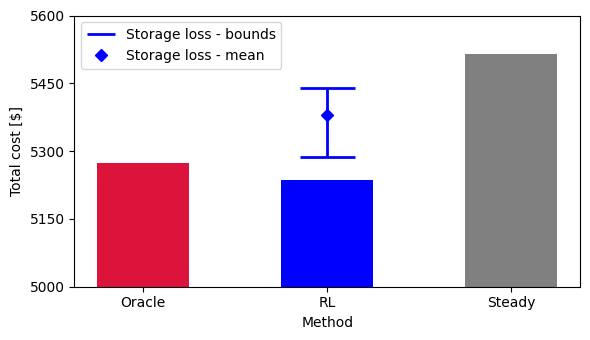

In [15]:
import matplotlib.pyplot as plt

# Assume these variables are already defined:
# denorm_obs_array, oracle, total_cost, length, delta_S

prices = denorm_obs_array[:, 2]

cost_oracle = oracle['C']
cost_rl = total_cost
cost_steady = np.ones(length) @ prices

box_max = delta_S * prices.max() + cost_rl
box_min = delta_S * prices.min() + cost_rl
box_mean = delta_S * prices.mean() + cost_rl

# Data for bar plot
costs = [cost_oracle, cost_rl, cost_steady]
labels = ['Oracle', 'RL', 'Steady']
positions = [0, 1, 2]
bar_width = 0.5

plt.figure(figsize=(6, 3.5))
plt.bar(positions, costs, width=bar_width, color=['crimson', 'blue', 'grey'])
plt.xticks(positions, labels)
plt.ylim((5000, 5600))
plt.yticks([5000+150*n for n in range(5)])
plt.xlabel("Method")
plt.ylabel("Total cost [$]")
# plt.title("Cost Comparison")

# For the RL bar (position 1), overlay the vertical line with horizontal caps.
x_center = positions[1]
cap_width = bar_width * 0.6  # Adjust cap width as needed

# Draw the vertical line from box_min to box_max
plt.vlines(x_center, box_min, box_max, colors='blue', linestyles='solid', linewidth=2, label='Storage loss - bounds')

# Draw horizontal caps at the top (box_max) and bottom (box_min)
plt.hlines(box_min, x_center - cap_width/2, x_center + cap_width/2, colors='blue', linestyles='solid', linewidth=2)
plt.hlines(box_max, x_center - cap_width/2, x_center + cap_width/2, colors='blue', linestyles='solid', linewidth=2)

# Mark the RL mean with a diamond marker
plt.plot(x_center, box_mean, 'D', color='blue', label='Storage loss - mean')

# Combine legend entries, avoiding duplicates
handles, legend_labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(legend_labels, handles))
plt.legend(unique.values(), unique.keys())
plt.tight_layout()
plt.savefig('./figures/cost_comparison.png', dpi=450)

plt.show()